In [1]:
%load_ext Cython

In [2]:
%matplotlib nbagg      
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from inter_arrival_analysis import genera_tiempos_entre_pulsos, \
                                   grafica_histograma_interarrivals
    
from modules.io_modules import read_timestamp
from modules.alfa_rossi_preprocesamiento import corrige_roll_over

## Se generan los tiempos entre pulsos

In [3]:
nombres = [                                                                    
           '../datos/medicion04.a.inter.D1.bin',                                
            '../datos/medicion04.a.inter.D2.bin',
]                                                                   
unidad = 'tiempo'                                                              
nbins = 10000                                                                  
yscale = 'log'

# Para la leyenda del gráfico                                                  
archivos = []                                                                  
for nombre in nombres:                                                         
    archivos.append(nombre.rsplit('/')[-1])
    
# Se generan los tiempos entre pulsos                                          
tiempos, unidad = genera_tiempos_entre_pulsos(nombres, unidad)

El archivo tiene encabezado
--------------------------------------------------
Tiempo expresado en [s] con numpy.ndarray de float64
El archivo tiene encabezado
--------------------------------------------------
Tiempo expresado en [s] con numpy.ndarray de float64


### Graficación del histograma de tiempo entre pulsos

<IPython.core.display.Javascript object>


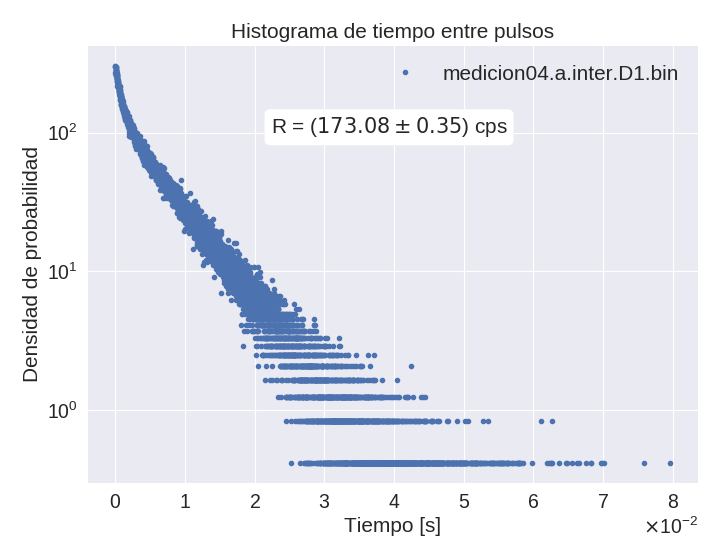

--------------------------------------------------
Nombre: medicion04.a.inter.D1.bin
R = 173.08+/-0.35
--------------------------------------------------


<IPython.core.display.Javascript object>


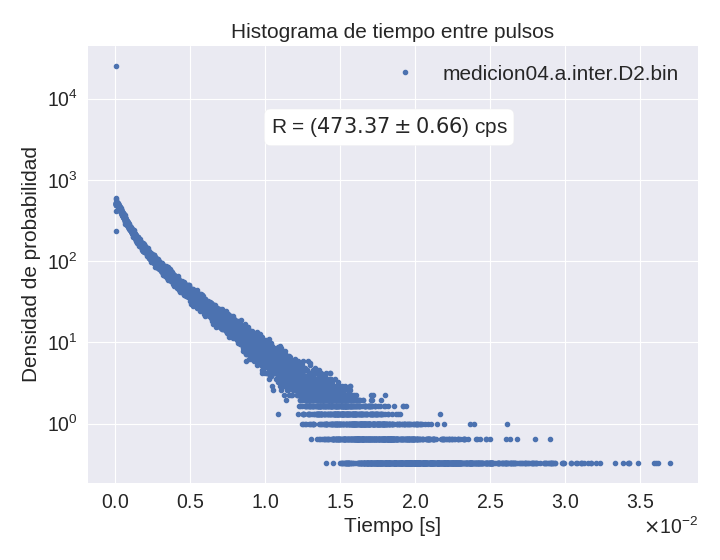

--------------------------------------------------
Nombre: medicion04.a.inter.D2.bin
R = 473.4+/-0.7
--------------------------------------------------


In [4]:
for tiempo, archivo in zip(tiempos, archivos):                                 
    # Opciones para graficar                                                   
    parametros_histo = {'unidad': unidad,                                      
                        'nbins': nbins,
                        'yscale': yscale,                                      
                        'nombre': archivo,                                     
                        }                                                      
    # Graficación                                                              
    grafica_histograma_interarrivals(tiempo, **parametros_histo) 

## Análisis del tiempo muerto

<IPython.core.display.Javascript object>


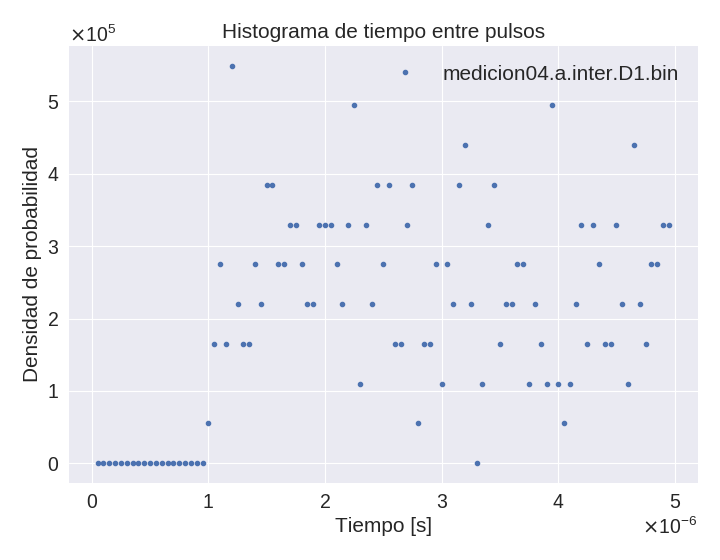

--------------------------------------------------
Nombre: medicion04.a.inter.D1.bin
R = 173.08+/-0.35
--------------------------------------------------


<IPython.core.display.Javascript object>


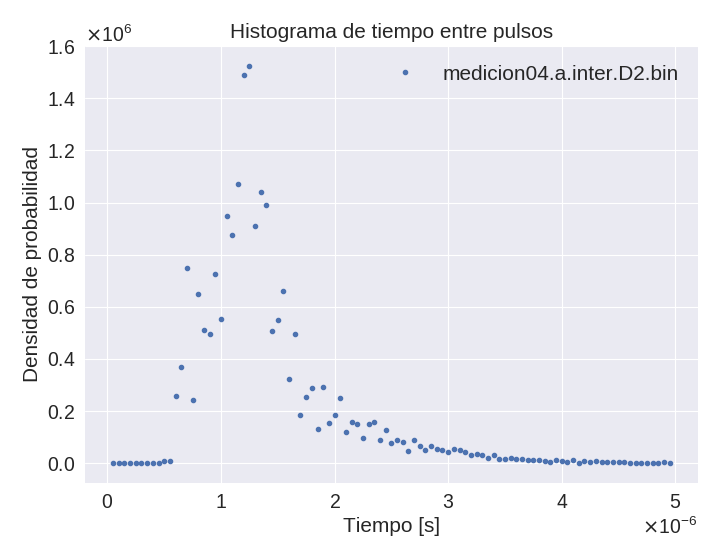

--------------------------------------------------
Nombre: medicion04.a.inter.D2.bin
R = 473.4+/-0.7
--------------------------------------------------


In [5]:
# Especifico los tiempos que quiero mirar
# De lo contrario puede tardar mucho en procesar
bins =np.linspace(0.0, 5e-6, 100, endpoint=False)

figs = []
for tiempo, archivo in zip(tiempos, archivos):                                 
    # Opciones para graficar                                                   
    parametros_histo = {'unidad': unidad,                                      
                        'nbins': bins,
                        'yscale': 'linear',                                      
                        'nombre': archivo,  
                        'anota': False,
                        }                                                      
    # Graficación                                                              
    fig = grafica_histograma_interarrivals(tiempo, **parametros_histo)
    figs.append(fig)

## Simulación de un tiempo muerto no-paralizable

In [6]:
%%cython
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def genera_no_paralizable(unsigned long[:] data, int tau_np, unsigned long flag):
    cdef unsigned long[:] result
    cdef int i, j, N_tot
    result = data.copy()
    N_tot = result.size
    for i in range(N_tot):
        if result[i] != flag:
            for j in range(1, N_tot-i):
                if result[i+j] - result[i] <= tau_np:
                    result[i+j] = flag
                else:
                    break
        else:
            pass
    return result

In [7]:
# %%timeit
# u3 = genera_no_paralizable(datos, p_tau, 2**64 -1)

In [8]:
tiempos, header = read_timestamp(nombres[1])
datos = corrige_roll_over(tiempos)

# Tiempo muero paralizable [segundos]
tau_np_seg = 1e-3
# Tiempo del reloj usado para contar
tb = 12.5e-9
# Tiempo muerto paralizable [pulsos de reloj]
tau_np = np.uint64(tau_np_seg / tb)
print('Tiempo muerto no-paralizable: {:.2E} segundos ({:d} pulsos de reloj)'.format(tau_np_seg, tau_np))

El archivo tiene encabezado
--------------------------------------------------
Corrigiendo roll-over del archivo [0]
Tipo de dato inicial: >u4
Tipo de dato final uint64
--------------------------------------------------
Tiempo muerto no-paralizable: 1.00E-03 segundos (80000 pulsos de reloj)


In [9]:
# Flag que identifica los pulsos que voy a eliminar
flag = 2**64 -1
if any(datos==flag):
    raise OverflowError('No se puede usar el flag con estos datos')

# Pone flag en los pulsos que tengo que sacar
datos_con_flag = genera_no_paralizable(datos, tau_np, flag)
datos_con_flag = np.asarray(datos_con_flag)
# Busca los índices de los pulsos con flag
zeros_indx = np.where(datos_con_flag==flag)
# Borra los pulsos
datos_np_sim = np.delete(datos_con_flag, zeros_indx[0])
# Calcula tiempo entre pulsos
dt_np_sim = np.diff(datos_np_sim)

print('De los {} pulsos originales se quitaron {}.'.format(datos.size, zeros_indx[0].size))
print('Quedan datos con {} pulsos'.format(datos_np_sim.size))

De los 831400 pulsos originales se quitaron 339004.
Quedan datos con 492396 pulsos


<IPython.core.display.Javascript object>


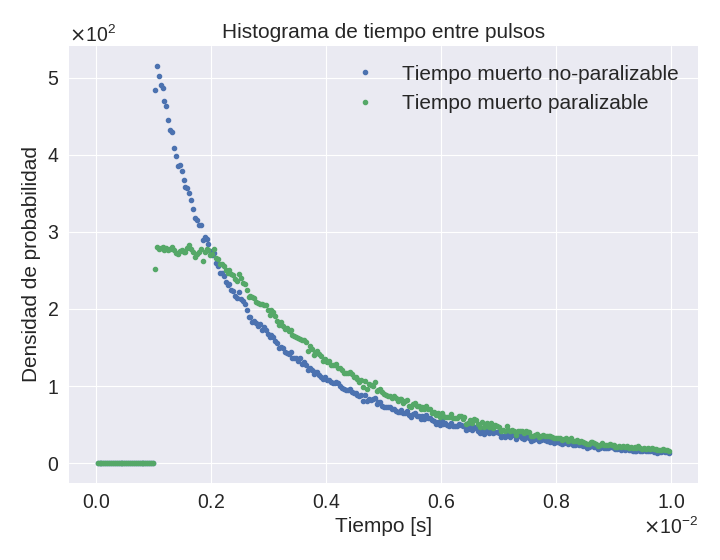

--------------------------------------------------
Nombre: Tiempo muerto no-paralizable
R = 280.35+/-0.32
--------------------------------------------------


In [10]:
# Especifico los tiempos que quiero mirar
# De lo contrario puede tardar mucho en procesar
bins_s =np.linspace(0.0, tau_np_seg*10, 301, endpoint=False)

# Convierto los pulsos a segundos
new_dt_s = dt_np_sim * tb
                                
# Opciones para graficar                                                   
parametros_histo = {'unidad': 'tiempo',                                      
                    'nbins': bins_s,
                    'yscale': 'linear',                                      
                    'nombre': 'Tiempo muerto no-paralizable',  
                    'anota': False,
                    }                                                      
# Graficación                                                              
fig_np = grafica_histograma_interarrivals(new_dt_s, **parametros_histo)

## Simulación de un tiempo muerto paralizable

In [11]:
def genera_p_deadtime(datos_in, tau):                                                
                                                                                   
    _dts = np.diff(datos_in)                                                           
                                                                                     
    indx_to_remove = np.where(_dts <= tau)[0] + 1                                   
    datos_p_simulados = np.delete(datos_in, indx_to_remove)                           
                                                                                                                 
    return datos_p_simulados     

In [12]:
tiempos, header = read_timestamp(nombres[1])
datos = corrige_roll_over(tiempos)

# Tiempo muero paralizable [segundos]
tau_p_seg = 1e-3
# Tiempo del reloj usado para contar
tb = 12.5e-9
# Tiempo muerto paralizable [pulsos de reloj]
tau_p = np.uint64(tau_p_seg / tb)
print('Tiempo muerto paralizable: {:.2E} segundos ({:d} pulsos de reloj)'.format(tau_p_seg, tau_p))

El archivo tiene encabezado
--------------------------------------------------
Corrigiendo roll-over del archivo [0]
Tipo de dato inicial: >u4
Tipo de dato final uint64
--------------------------------------------------
Tiempo muerto paralizable: 1.00E-03 segundos (80000 pulsos de reloj)


--------------------------------------------------
Nombre: Tiempo muerto paralizable
R = 251.44+/-0.28
--------------------------------------------------


<IPython.core.display.Javascript object>


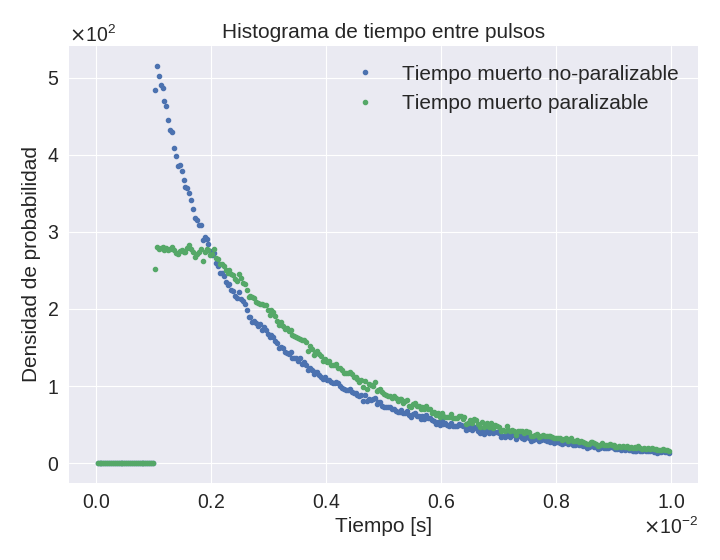

In [13]:
# Simula los datos con el tiempo muerto paralizable
datos_p_sim = genera_p_deadtime(datos, tau_p)
# Crea los tiempos entre pulsos
dt_p_sim = np.diff(datos_p_sim)

# Especifico los tiempos que quiero mirar
# De lo contrario puede tardar mucho en procesar

# bins_s = np.linspace(0.0, tau_p_seg*10, 301, endpoint=False)


# Convierto los pulsos a segundos
dt_p_sim_s = dt_p_sim * tb
                                
# Opciones para graficar                                                   
parametros_histo = {'unidad': 'tiempo',                                      
                    'nbins': bins_s,
                    'yscale': 'linear',                                      
                    'nombre': 'Tiempo muerto paralizable',  
                    'anota': False,
                    'fig': fig_np,
                    }                                                      
# Graficación                                                              
grafica_histograma_interarrivals(dt_p_sim_s, **parametros_histo)
fig_np